## Assignment S11 - (Gradcam )
This notebook is for displaying Gradcam ResNet18 model.

In [ ]:
%matplotlib inline
import autoreload
%load_ext autoreload
%autoreload

In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git --no-cache-dir

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-c_9nip5i
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-c_9nip5i
  Resolved https://github.com/albumentations-team/albumentations.git to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=7a3f927f8a3cbe5dfc42f2a75756e303b9ecb6b279458dfdc6acff7b4fb20b6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-o2mqm5zl/wheels/f9/34/b6/eb7adf92e69b5629d7de6904c0d4ac4e5050b18ce065bab4e1
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


## Mount the google drive

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [ ]:
!git clone https://github.com/monimoydebp/session11.git

Cloning into 'session11'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66
Receiving objects: 100% (66/66), 1.81 MiB | 21.25 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [ ]:
!cp -rf '/content/session11/data_loaders' .
!cp -rf '/content/session11/data_transformations' .
!cp -rf '/content/session11/models' .
!cp -rf '/content/session11/utils' .
!cp -rf '/content/session11/main.py' .

## Import all the libraries

In [ ]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_cifar10_resnet import get_train_transform, get_test_transform
from data_loaders.cifar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.resnet18 import ResNet18
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy
from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images
from utils.gradcam_utils import process_grad




In [ ]:
conter = 1


Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [ ]:
import main
trainloader, testloader, classes = main.train_test_loader()
model,device = main.get_model_parameters()

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:02<00:00, 84143493.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


## Visualizing some of the images in train dataset



## 2. Define a Convolution Neural Network

I have defined the basic ResNet18 model and added dropout to it



In [ ]:
main.summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         Dropout2d-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        Dropout2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

/content/models/resnet18.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 20 epochs to train the model

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epochs = 20
lr = 0.01
momentum = 0.9
PATH = '/content/drive/My Drive/cifar10_resnet18.pth'
train_losses, test_losses,train_acc,test_acc = main.perform_training(model, device, trainloader, testloader,  train_losses, test_losses,train_acc,test_acc, PATH, epochs, lr, momentum)


EPOCH: 0


Loss=1.442049264907837 Batch_id=195 Accuracy=35.58: 100%|██████████| 196/196 [00:45<00:00,  4.33it/s]



Test set: Average loss: 1.5722, Accuracy: 4332/10000 (43.32%)

Test Accuracy: 43.32 has increased. Saving the model
EPOCH: 1


Loss=1.5338133573532104 Batch_id=195 Accuracy=45.90: 100%|██████████| 196/196 [00:45<00:00,  4.30it/s]



Test set: Average loss: 1.1325, Accuracy: 6038/10000 (60.38%)

Test Accuracy: 60.38 has increased. Saving the model
EPOCH: 2


Loss=1.3467878103256226 Batch_id=195 Accuracy=51.84: 100%|██████████| 196/196 [00:46<00:00,  4.21it/s]



Test set: Average loss: 1.1090, Accuracy: 6078/10000 (60.78%)

Test Accuracy: 60.78 has increased. Saving the model
EPOCH: 3


Loss=1.1652313470840454 Batch_id=195 Accuracy=55.89: 100%|██████████| 196/196 [00:45<00:00,  4.29it/s]



Test set: Average loss: 0.8931, Accuracy: 6912/10000 (69.12%)

Test Accuracy: 69.12 has increased. Saving the model
EPOCH: 4


Loss=1.0549232959747314 Batch_id=195 Accuracy=58.75: 100%|██████████| 196/196 [00:45<00:00,  4.33it/s]



Test set: Average loss: 0.7993, Accuracy: 7215/10000 (72.15%)

Test Accuracy: 72.15 has increased. Saving the model
EPOCH: 5


Loss=0.9877794981002808 Batch_id=195 Accuracy=61.04: 100%|██████████| 196/196 [00:45<00:00,  4.28it/s]



Test set: Average loss: 0.8585, Accuracy: 7030/10000 (70.30%)

EPOCH: 6


Loss=1.0950812101364136 Batch_id=195 Accuracy=62.98: 100%|██████████| 196/196 [00:46<00:00,  4.26it/s]



Test set: Average loss: 0.6751, Accuracy: 7682/10000 (76.82%)

Test Accuracy: 76.82 has increased. Saving the model
EPOCH: 7


Loss=0.8100839853286743 Batch_id=195 Accuracy=64.39: 100%|██████████| 196/196 [00:45<00:00,  4.35it/s]



Test set: Average loss: 0.7464, Accuracy: 7488/10000 (74.88%)

EPOCH: 8


Loss=1.0878289937973022 Batch_id=195 Accuracy=65.73: 100%|██████████| 196/196 [00:45<00:00,  4.33it/s]



Test set: Average loss: 0.6475, Accuracy: 7811/10000 (78.11%)

Test Accuracy: 78.11 has increased. Saving the model
EPOCH: 9


Loss=0.9211626052856445 Batch_id=195 Accuracy=66.62: 100%|██████████| 196/196 [00:46<00:00,  4.22it/s]



Test set: Average loss: 0.6562, Accuracy: 7787/10000 (77.87%)

EPOCH: 10


Loss=1.0333921909332275 Batch_id=195 Accuracy=67.92: 100%|██████████| 196/196 [00:45<00:00,  4.32it/s]



Test set: Average loss: 0.6162, Accuracy: 7911/10000 (79.11%)

Test Accuracy: 79.11 has increased. Saving the model
EPOCH: 11


Loss=0.6622820496559143 Batch_id=195 Accuracy=69.14: 100%|██████████| 196/196 [00:45<00:00,  4.31it/s]



Test set: Average loss: 0.5690, Accuracy: 8072/10000 (80.72%)

Test Accuracy: 80.72 has increased. Saving the model
EPOCH: 12


Loss=0.7159744501113892 Batch_id=195 Accuracy=69.62: 100%|██████████| 196/196 [00:45<00:00,  4.28it/s]



Test set: Average loss: 0.5500, Accuracy: 8112/10000 (81.12%)

Test Accuracy: 81.12 has increased. Saving the model
EPOCH: 13


Loss=0.6568178534507751 Batch_id=195 Accuracy=70.31: 100%|██████████| 196/196 [00:46<00:00,  4.25it/s]



Test set: Average loss: 0.5527, Accuracy: 8134/10000 (81.34%)

Test Accuracy: 81.34 has increased. Saving the model
EPOCH: 14


Loss=0.8263927698135376 Batch_id=195 Accuracy=70.83: 100%|██████████| 196/196 [00:45<00:00,  4.28it/s]



Test set: Average loss: 0.6382, Accuracy: 7899/10000 (78.99%)

EPOCH: 15


Loss=1.0794854164123535 Batch_id=195 Accuracy=71.72: 100%|██████████| 196/196 [00:45<00:00,  4.28it/s]



Test set: Average loss: 0.5565, Accuracy: 8193/10000 (81.93%)

Test Accuracy: 81.93 has increased. Saving the model
EPOCH: 16


Loss=0.9456732869148254 Batch_id=195 Accuracy=72.22: 100%|██████████| 196/196 [00:45<00:00,  4.26it/s]



Test set: Average loss: 0.5133, Accuracy: 8294/10000 (82.94%)

Test Accuracy: 82.94 has increased. Saving the model
EPOCH: 17


Loss=0.6797829866409302 Batch_id=195 Accuracy=72.24: 100%|██████████| 196/196 [00:45<00:00,  4.31it/s]



Test set: Average loss: 0.5412, Accuracy: 8268/10000 (82.68%)

EPOCH: 18


Loss=1.014331579208374 Batch_id=195 Accuracy=73.57: 100%|██████████| 196/196 [00:45<00:00,  4.32it/s]



Test set: Average loss: 0.4725, Accuracy: 8427/10000 (84.27%)

Test Accuracy: 84.27 has increased. Saving the model
EPOCH: 19


Loss=0.7022676467895508 Batch_id=195 Accuracy=73.59: 100%|██████████| 196/196 [00:45<00:00,  4.31it/s]



Test set: Average loss: 0.4599, Accuracy: 8450/10000 (84.50%)

Test Accuracy: 84.5 has increased. Saving the model


## 5. Test the network on the test data


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)



Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

Accuracy of the network on the 10000 test images: 84.50 %


The accuracy 84.50 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 92 %
Accuracy of  bird : 100 %
Accuracy of   cat : 72 %
Accuracy of  deer : 76 %
Accuracy of   dog : 60 %
Accuracy of  frog : 72 %
Accuracy of horse : 100 %
Accuracy of  ship : 95 %
Accuracy of truck : 76 %


In [ ]:
incorrect_image_list =[]
predicted_label_list =[]
correct_label_list = []
incorrect_image_list, predicted_label_list, correct_label_list = main.incorrect_image(model, device, testloader,incorrect_image_list, predicted_label_list, correct_label_list)

/content/models/resnet18.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## Display Misclassified Images

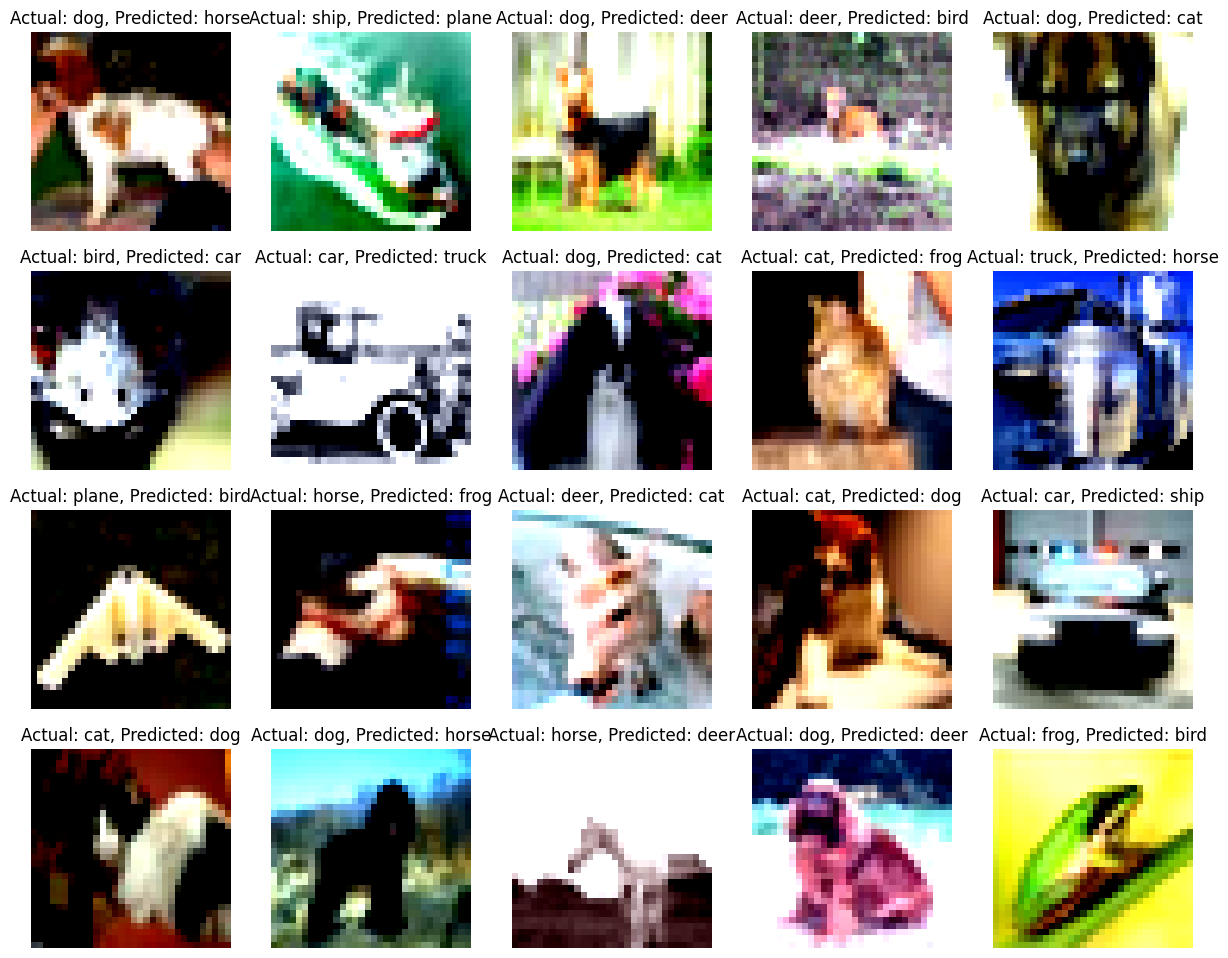

In [ ]:
display_misclassfied_ciphar10_images(testloader, model, device, classes, 20)

## GRADCAM

In [ ]:
predicted_lb =[]
correct_lb =[]
for i in range(20):
  #print("Predicted is",predicted_label_list[i])
  predicted_lb.append(predicted_label_list[i])
  #print("Correct is",correct_label_list[i])
  correct_lb.append(correct_label_list[i])

In [ ]:
incorrect_images_disp  = incorrect_image_list[0:20]

In [ ]:
predicted_label_list = predicted_label_list[0:20]

In [ ]:
correct_label_list = predicted_label_list[0:20]

20


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 360MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 77.6MB/s]


input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Process Grad get gradcame
input.size()= torch.Size([1, 3, 224, 224])
Write Cam Image
Proces

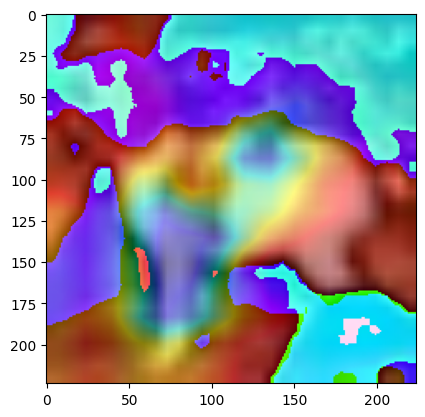

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

incorrect_images = []

for i in range(20) :
  img = incorrect_images_disp[i]
  img = img / 2 + 0.5
  #img = img.numpy()
  img=np.transpose(img, (1, 2, 0))
  img=img*255
  incorrect_images.append(img)

print(len(incorrect_images))
cam_images=process_grad(incorrect_images,model)
plt.imshow(cam_images[0])

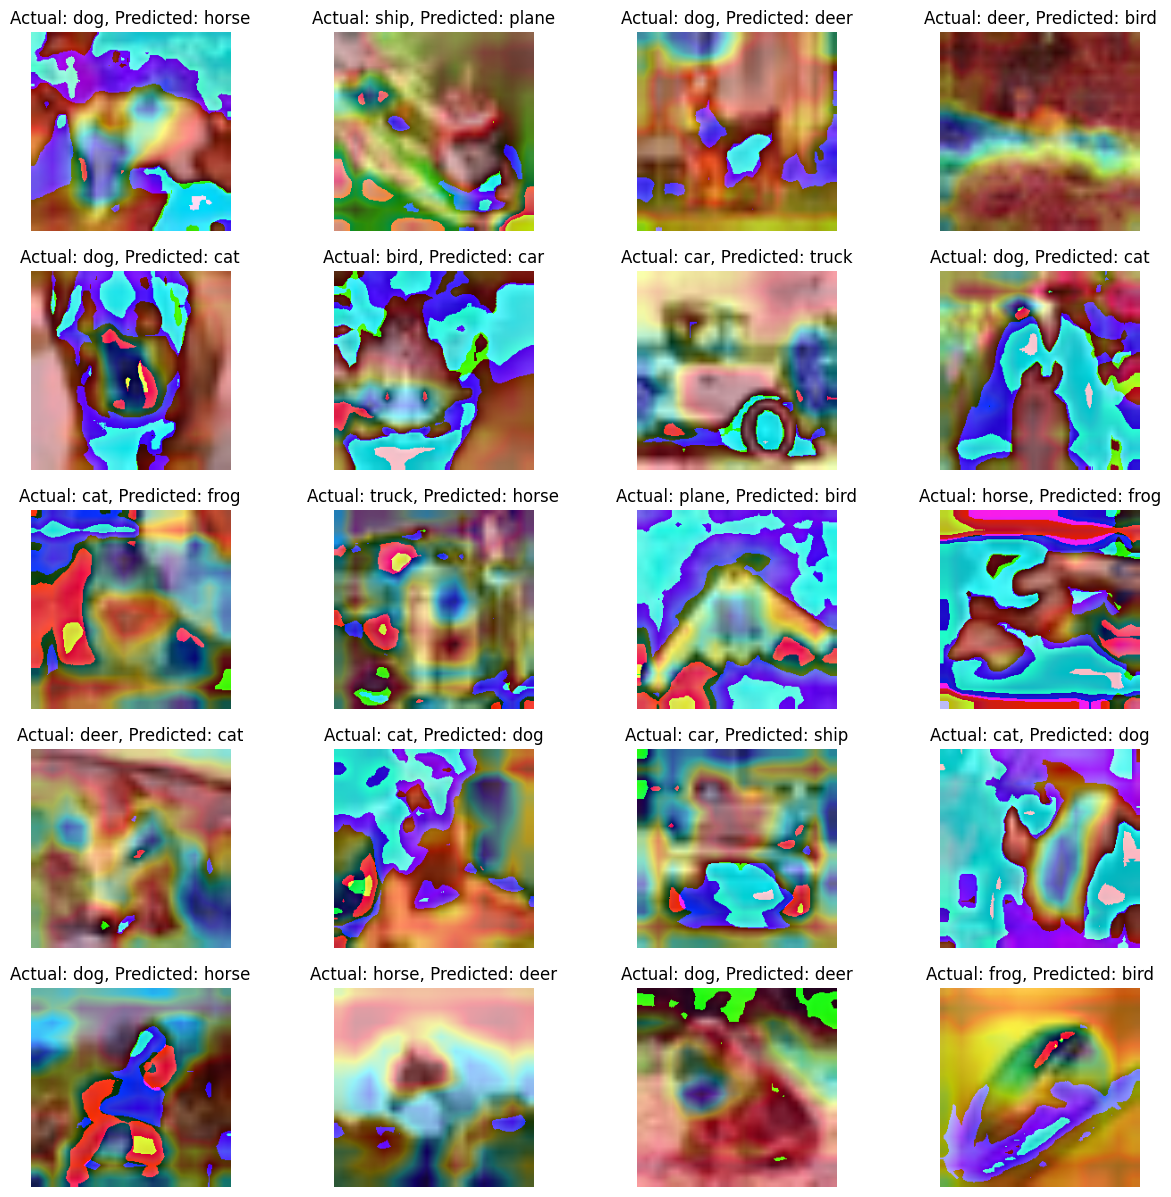

In [ ]:
plt.figure(figsize=(15,15))
columns = 5
i= 0
    # Display the list of 25 misclassified images
for index, image in enumerate(cam_images) :
  ax = plt.subplot(5, 4, i+1)
  ax.set_title("Actual: " + str(classes[correct_lb[index]]) + ", Predicted: " + str(classes[predicted_lb[index]]))
  ax.axis('off')
    #plt.imshow(image)
  plt.imshow(image)
  i +=1
  if i==20:
    break